This notebook uses the q_learning_lib.py to perform Q-learning on tic tac toe.

A variation of different hyperparameters are tried, against many different cases.

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import q_learning_lib as qlb
import json
import os

Assuming alpha = 0.1 and tau = e, lets record what happens in each of the 4 cases of training (optimal, non optimal, x, o)

In [24]:
NUMBER_OF_BATCHES = 1000
BATCH_SIZE = 10
NUMBER_OF_GAMES = NUMBER_OF_BATCHES * BATCH_SIZE

In [25]:
def make_alpha(rate_val):
    """Function factorie for creating different alpha functions"""
    def alpha(turn):

        #return rate_val * (BATCH_SIZE * NUMBER_OF_BATCHES - turn) / (NUMBER_OF_BATCHES * BATCH_SIZE)
        #return 0.5 / (1 + rate_val * turn) 

        return 0.5 * np.exp(-rate_val * turn) #my new proposed fucntion

    return alpha

def make_tau(rate_val):
    """Function factorie for creating different tau functions"""
    def tau(turn):
        #return 1 + max_rate * (turn) / (NUMBER_OF_BATCHES * BATCH_SIZE) 
        #return 1 + (max_rate - 1) * ((turn/(NUMBER_OF_BATCHES * BATCH_SIZE))**3)
        return np.pow(10000, np.pow(turn/(NUMBER_OF_GAMES), rate_val )) #my new proposed function

    return tau


In [26]:

def record_params(results, filename):

    df = pd.DataFrame(results[::-1], columns=['o_win', 'draw', 'x_win'])

    # Save to CSV (index=False prevents it from adding a row-number column)
    df.to_csv(filename, index=False)

In [27]:
alpha_exponents = np.linspace(-4, -10, 10)
alpha_values = np.pow(10, alpha_exponents)
tau_exponents = np.linspace(-3, 3, 10 )
tau_values = np.pow(10, tau_exponents)
print(alpha_values)
print(tau_values)

[1.00000000e-04 2.15443469e-05 4.64158883e-06 1.00000000e-06
 2.15443469e-07 4.64158883e-08 1.00000000e-08 2.15443469e-09
 4.64158883e-10 1.00000000e-10]
[1.00000000e-03 4.64158883e-03 2.15443469e-02 1.00000000e-01
 4.64158883e-01 2.15443469e+00 1.00000000e+01 4.64158883e+01
 2.15443469e+02 1.00000000e+03]


In [28]:
def try_different_hyperparams(alpha_rates, tau_rates, player, strategy, folder=""):
    """this functions tries a variation of different hyperparameters
    results from every single iteration are saved in a .csv file
    how alpha params, tau values affect the final winrates is recorded in a pandas df and also saved to a file """
 
    df_list = [] #will be turned to a df later
    
    for a, alpha_rate in enumerate(alpha_rates): 
        for b, tau_rate in enumerate(tau_rates):

            #trains
            Q_Table_x_optimal, results = qlb.perform_training(player, strategy, NUMBER_OF_BATCHES, BATCH_SIZE, False, make_alpha(alpha_rate), make_tau(tau_rate))

            results = results/(BATCH_SIZE * 50)
        
            #records the resultsplayer_x_label='x', player_o_label='o', 
            filename = f"parameter_results/{player}_vs_{strategy}/_opponent_alpha_{alpha_rate}_tau_{tau_rate}.csv"
            record_params(results, filename)

            
            #records end winrates vs hyperparams
            o_winrate = np.mean(results[:, 0][-5:])
            drawrate = np.mean(results[:, 1][-5:])
            x_winrate = np.mean(results[:, 2][-5:])
            new_results = {'alpha_rate': alpha_rate, 'tau_rate': tau_rate, 'o_winrate': o_winrate, 'drawrate': drawrate, 'x_winrate': x_winrate}
            df_list.append(new_results)

            print(f"{player}_vs_{strategy}: {((a * 10 + b + 1)/(len(alpha_rates) * len(tau_values))) * 100:.2f}%")
            print(f"'alpha_rate' {alpha_rate}, 'tau_rate': {tau_rate}, 'o_winrate': {o_winrate:.3f}, 'drawrate': {drawrate:.3f}, 'x_winrate': {x_winrate:.3f}")

    df = pd.DataFrame(df_list) 
    df.to_csv(f"parameter_results/{player}_vs_{strategy}/hyperparams.csv", index=False)

In [29]:
try_different_hyperparams(alpha_values, tau_values, 'x', 'perfect')
#try_different_hyperparams(alpha_values, tau_values, 'o', 'perfect')
#try_different_hyperparams(alpha_values, tau_values, 'x', 'random')
#try_different_hyperparams(alpha_values, tau_values, 'o', 'random')


x_vs_perfect: 1.00%
'alpha_rate' 0.0001, 'tau_rate': 0.001, 'o_winrate': 0.018, 'drawrate': 0.982, 'x_winrate': 0.000
x_vs_perfect: 2.00%
'alpha_rate' 0.0001, 'tau_rate': 0.004641588833612777, 'o_winrate': 0.020, 'drawrate': 0.980, 'x_winrate': 0.000
x_vs_perfect: 3.00%
'alpha_rate' 0.0001, 'tau_rate': 0.021544346900318832, 'o_winrate': 0.017, 'drawrate': 0.983, 'x_winrate': 0.000
x_vs_perfect: 4.00%
'alpha_rate' 0.0001, 'tau_rate': 0.1, 'o_winrate': 0.013, 'drawrate': 0.987, 'x_winrate': 0.000
x_vs_perfect: 5.00%
'alpha_rate' 0.0001, 'tau_rate': 0.46415888336127775, 'o_winrate': 0.006, 'drawrate': 0.994, 'x_winrate': 0.000
x_vs_perfect: 6.00%
'alpha_rate' 0.0001, 'tau_rate': 2.154434690031882, 'o_winrate': 0.017, 'drawrate': 0.983, 'x_winrate': 0.000
x_vs_perfect: 7.00%
'alpha_rate' 0.0001, 'tau_rate': 10.0, 'o_winrate': 0.466, 'drawrate': 0.534, 'x_winrate': 0.000
x_vs_perfect: 8.00%
'alpha_rate' 0.0001, 'tau_rate': 46.41588833612773, 'o_winrate': 0.800, 'drawrate': 0.200, 'x_winrate

In [30]:
df = pd.read_csv('parameter_results/x_vs_perfect/hyperparams.csv')

Text(0.5, 1.0, 'Max drawrate achieved 99.80%')

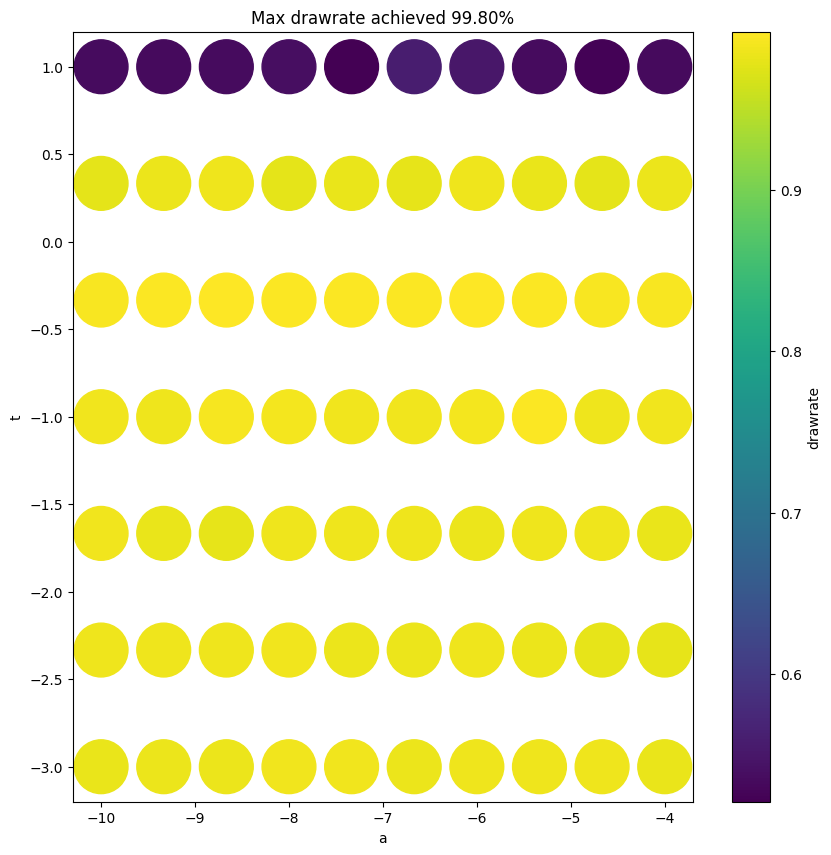

In [ ]:
# 1. Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

mask = df[np.log10(df['tau_rate']) < 1]#[np.log10(df['alpha_rate']) <= -4][np.log10(df['tau_rate']) <= -2]

x = np.log10(mask['alpha_rate'])
y = np.log10(mask['tau_rate'])
z = mask['drawrate']

# 2. Capture the return value (the "mappable")
scatter = ax.scatter(x, y, c=z, s=1500, cmap='viridis') # cmap is optional but recommended

# 3. Pass the scatter object to the colorbar
fig.colorbar(scatter, ax=ax, label=z.name)
ax.set_xlabel('a')
ax.set_ylabel('t')
ax.set_title(f"Max {z.name} achieved {z.max() * 100 :.2f}%")

In [32]:
make_alpha(np.pow(10.0, -7))
make_tau(np.pow(10.0, -6))

<function __main__.make_tau.<locals>.tau(turn)>

In [33]:
Q_Table, results = qlb.perform_training('x', 'perfect', 1000, 10, True, make_alpha(np.pow(10.0, -7)), make_tau(np.pow(10.0, -2)), 10)

o win   draw    x win
10
77.00%   23.00%   0.00%
20
61.00%   39.00%   0.00%
30
60.00%   40.00%   0.00%
40
50.00%   50.00%   0.00%
50
52.00%   48.00%   0.00%
60
21.00%   79.00%   0.00%
70
20.00%   80.00%   0.00%
80
18.00%   82.00%   0.00%
90
16.00%   84.00%   0.00%
100
15.00%   85.00%   0.00%
110
13.00%   87.00%   0.00%
120
6.00%   94.00%   0.00%
130
9.00%   91.00%   0.00%
140
8.00%   92.00%   0.00%
150
9.00%   91.00%   0.00%
160
10.00%   90.00%   0.00%
170
6.00%   94.00%   0.00%
180
7.00%   93.00%   0.00%
190
6.00%   94.00%   0.00%
200
4.00%   96.00%   0.00%
210
5.00%   95.00%   0.00%
220
4.00%   96.00%   0.00%
230
3.00%   97.00%   0.00%
240
5.00%   95.00%   0.00%
250
3.00%   97.00%   0.00%
260
5.00%   95.00%   0.00%
270
4.00%   96.00%   0.00%
280
6.00%   94.00%   0.00%
290
4.00%   96.00%   0.00%
300
2.00%   98.00%   0.00%
310
1.00%   99.00%   0.00%
320
4.00%   96.00%   0.00%
330
2.00%   98.00%   0.00%
340
3.00%   97.00%   0.00%
350
3.00%   97.00%   0.00%
360
4.00%   96.00%   0.00%
370

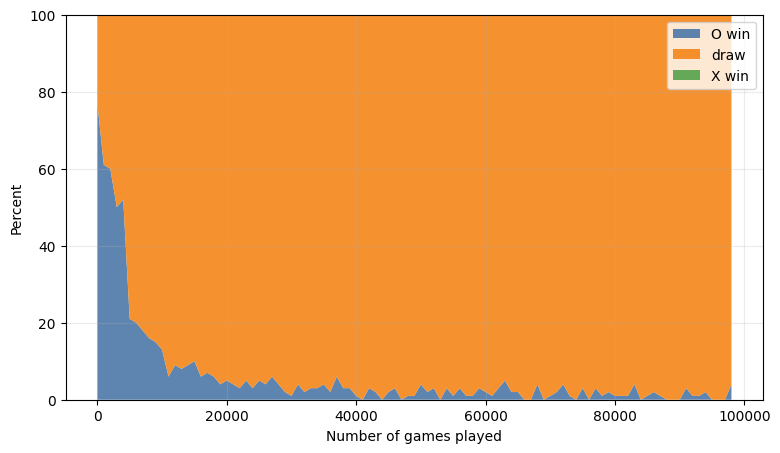

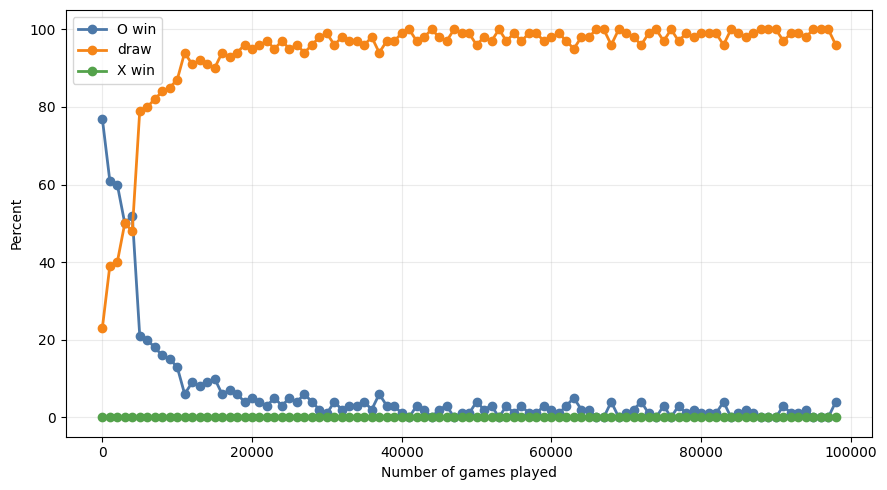

In [34]:
qlb.plot_triplet_ratios(results, 10)